# Кластеризация данных для компании "Северсталь"

## 1. Загрузка данных

In [4]:
# Подключаем нужные библиотеки
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import faiss
import math
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Создадим функцию, для отображения нужной информации о датафрейме
def df_info(df):
    display(df.head(10))
    df.info()
    display(df.describe())

In [6]:
# Считываем данные из csv файла и записываем их в переменную df
df = pd.read_excel("C:/Users/nikka/OneDrive/Рабочий стол/Severstal/EXPORT_YANDEX_v4.xlsx")

In [7]:
# Отобразим информацию о df
df_info(df)

,Номер Z-конфигурации,КлчПост/Потребн,Базовая ЕИ,Количество (Норматив),VID_PROD_GP,TOL,SHIRINA,DLINA,VID_TO,MARKA,ST_PROD
0,401077983,53.526,Т,1197.6,P0,58.0,2440,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
1,401090004,55.476,Т,1197.6,P0,32.2,2260,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
2,401090006,47.301,Т,1197.6,P0,33.0,1880,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
3,401090005,46.477,Т,1197.6,P0,38.0,1609,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
4,401089979,143.408,Т,1197.6,P0,58.0,2450,15588,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
5,401089980,143.408,Т,1197.6,P0,58.0,2450,15588,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
6,401089988,64.591,Т,1197.6,P0,38.0,2240,15578,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
7,401089996,155.545,Т,1197.6,P0,54.0,1750,15588,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
8,401089997,78.050,Т,1197.6,P0,31.3,2791,15649,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)
9,401089987,48.273,Т,1197.6,P0,24.8,2540,15650,БЕЗ ТО,S355NL,EN 10025-3:2019(Е)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Номер Z-конфигурации   1162 non-null   int64  
 1   КлчПост/Потребн        1162 non-null   float64
 2   Базовая ЕИ             1162 non-null   object 
 3   Количество (Норматив)  1162 non-null   float64
 4   VID_PROD_GP            1162 non-null   object 
 5   TOL                    1162 non-null   float64
 6   SHIRINA                1162 non-null   int64  
 7   DLINA                  1162 non-null   int64  
 8   VID_TO                 1162 non-null   object 
 9   MARKA                  1162 non-null   object 
 10  ST_PROD                1162 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 100.0+ KB


,Номер Z-конфигурации,КлчПост/Потребн,Количество (Норматив),TOL,SHIRINA,DLINA
count,1.162000e+03,1162.000000,1162.000000,1162.000000,1162.000000,1162.000000
mean,4.011756e+08,51.318040,1181.951464,31.681145,2055.856282,8872.553356
std,4.502185e+04,119.309281,51.417966,26.781364,518.731017,3689.762663
min,4.008269e+08,1.042000,1056.212000,8.000000,1300.000000,3000.000000
25%,4.011753e+08,14.502000,1160.000000,16.000000,1500.000000,6000.000000
50%,4.011866e+08,25.704000,1174.700000,22.215000,2000.000000,6300.000000
75%,4.012027e+08,53.649000,1197.600000,36.000000,2448.000000,12000.000000
max,4.012151e+08,1911.060000,2010.000000,240.000000,4412.000000,15698.000000


## 2. Предобработка данных

### 2.1 Удаление пропусков

**Определим кол-во пропусков**

In [11]:
df.isna().sum()

Номер Z-конфигурации     0
КлчПост/Потребн          0
Базовая ЕИ               0
Количество (Норматив)    0
VID_PROD_GP              0
TOL                      0
SHIRINA                  0
DLINA                    0
VID_TO                   0
MARKA                    0
ST_PROD                  0
dtype: int64

**Удалим строки с пропусками, в случае их наличия**

In [13]:
df = df.dropna()

### 2.2 Обработка дубликатов

**Найдем явные дубликаты**

In [16]:
df.duplicated().sum()

0

**Удалим явные дубликаты, в случае их наличия**

In [18]:
df = df.drop_duplicates()

## 3. Исследовательский анализ данных

In [20]:
# Разобьем признаки на числовые и категориальные
df_num_col = df.select_dtypes(include=['number']).columns
df_cat_col = df.select_dtypes(include=['object', 'category']).columns

**Проанализируем числовые признаки**

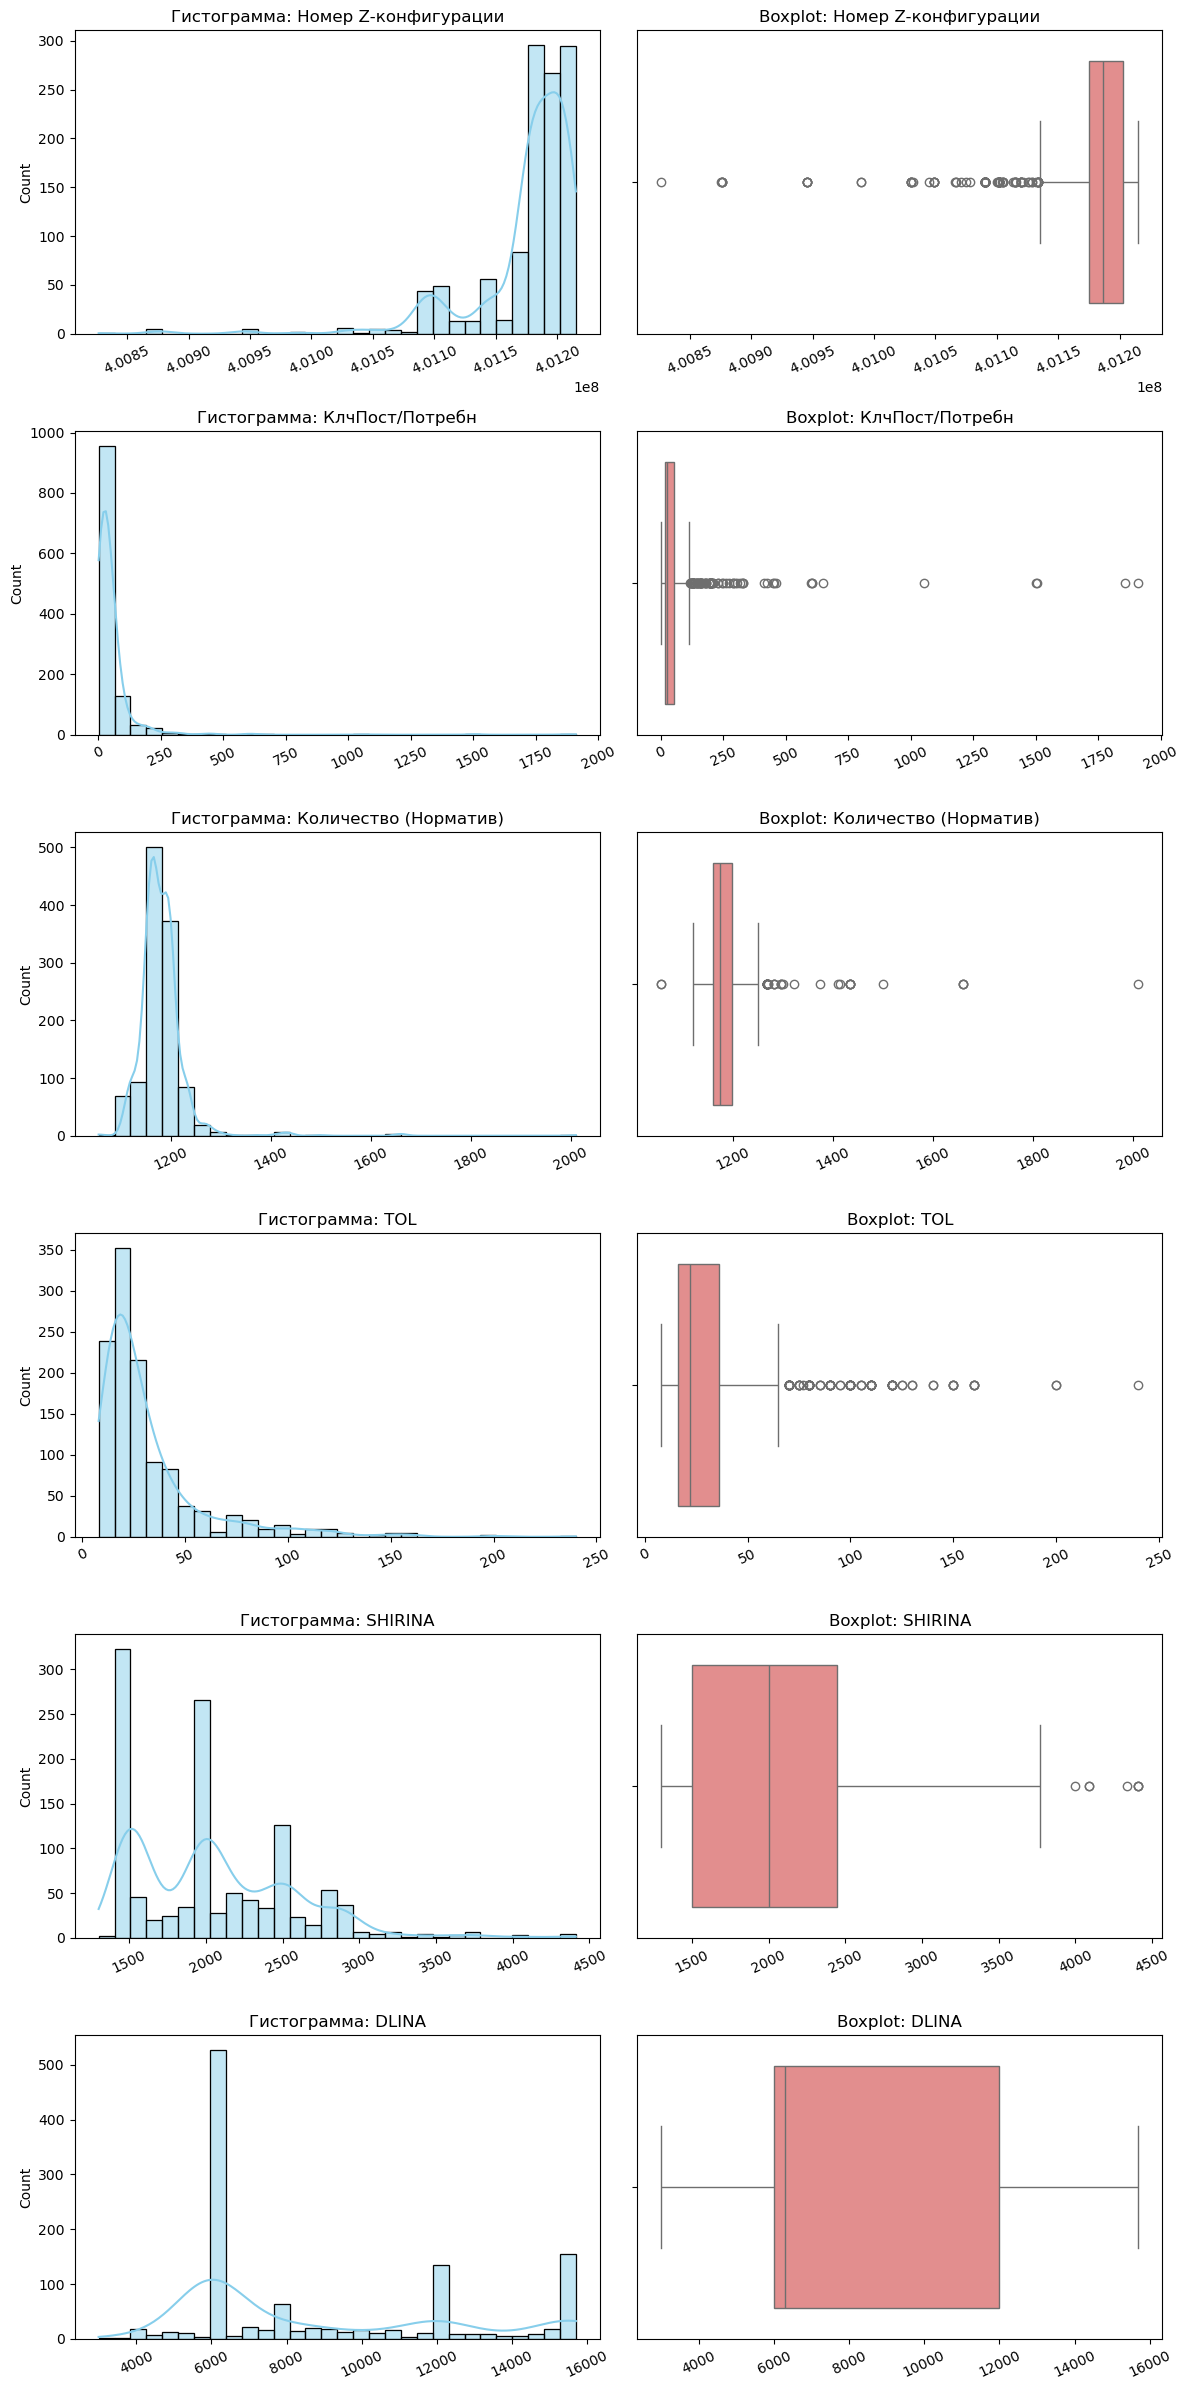

In [21]:
n_cols = 2  # кол-во колонок: один признак = 2 графика (hist + box)
num_cols = df_num_col  # список числовых признаков
n_rows = math.ceil(len(num_cols))  # столько строк, сколько признаков

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 4 * n_rows))
axes = axes.reshape(-1, 2)  # делаем доступ по [i][0] и [i][1]

for i, col in enumerate(num_cols):
    # Гистограмма
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i][0], color='skyblue')
    axes[i][0].set_title(f'Гистограмма: {col}')
    axes[i][0].set_xlabel('')
    axes[i][0].tick_params(axis='x', rotation=25)

    # Boxplot
    sns.boxplot(x=df[col], ax=axes[i][1], color='lightcoral')
    axes[i][1].set_title(f'Boxplot: {col}')
    axes[i][1].set_xlabel('')
    axes[i][1].tick_params(axis='x', rotation=25)

plt.tight_layout()
plt.show()

**Проанализируем категориальные признаки**

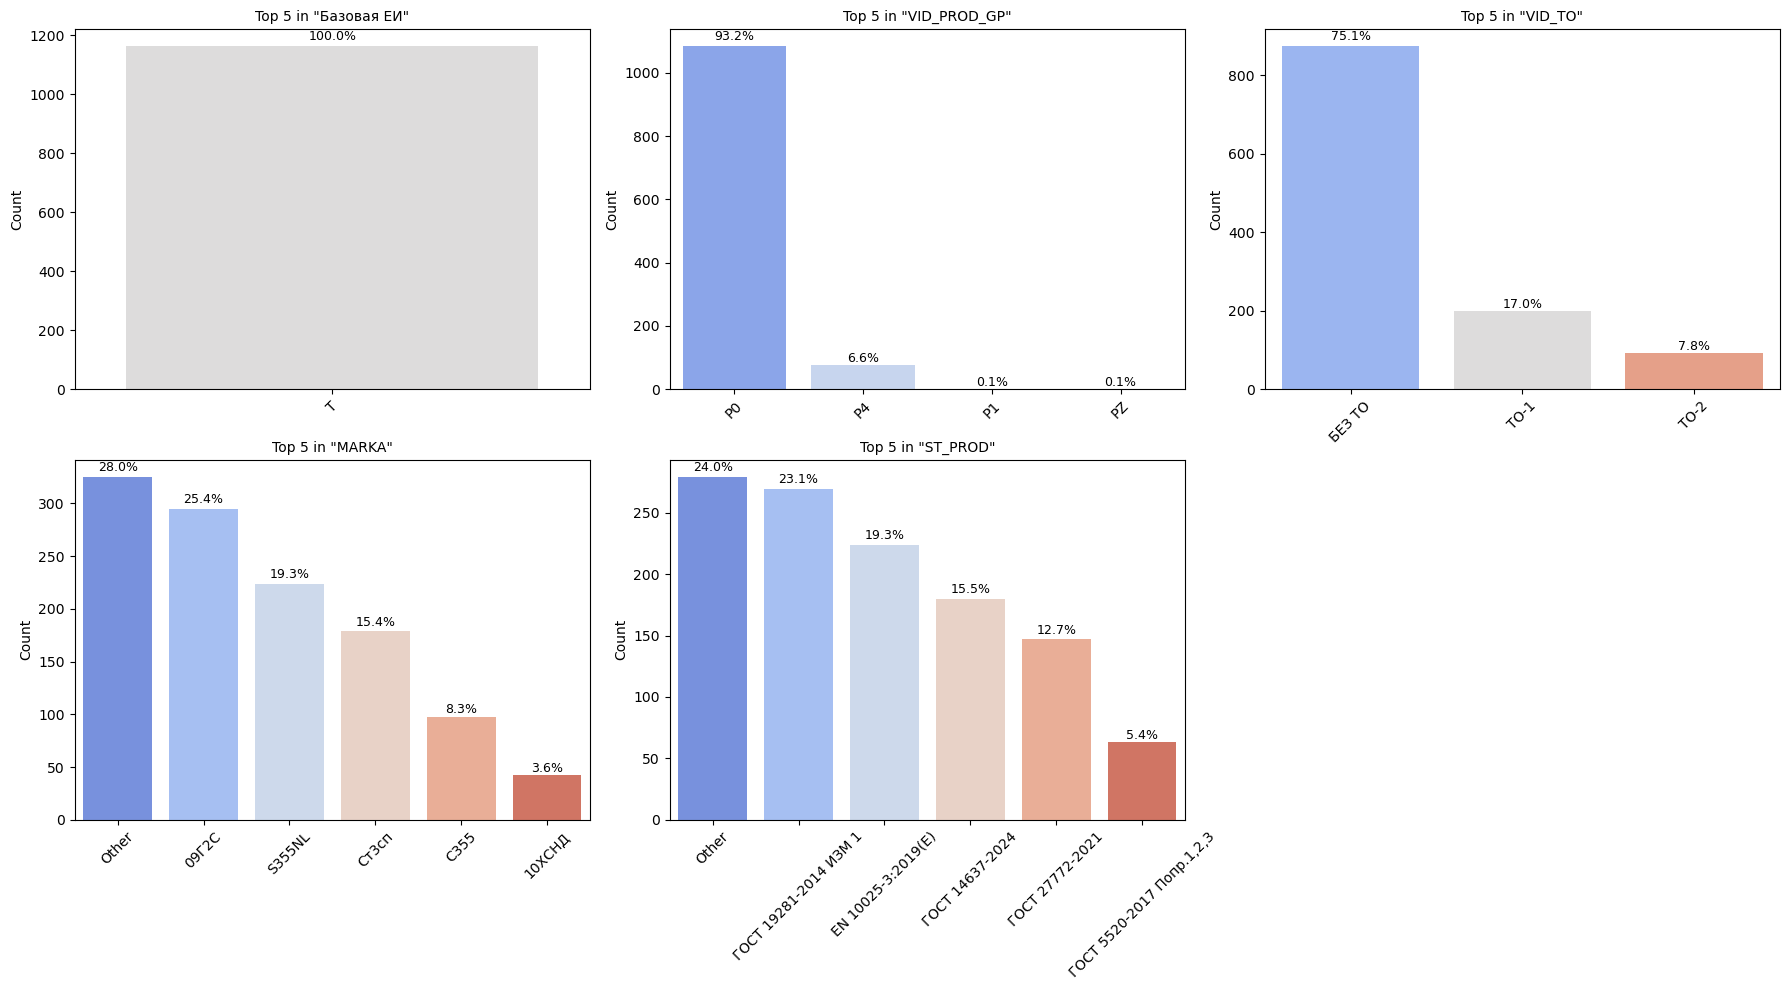

In [22]:
# Отобразим топ-5 категорий в каждом признаке
top_n = 5
n_cols = 3  # количество графиков в строке
cat_cols = df_cat_col  # список категориальных колонок
n_rows = math.ceil(len(cat_cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    # Подготовим данные с группировкой "Other"
    top_categories = df[col].value_counts().nlargest(top_n).index
    df_plot = df.copy()
    df_plot[col] = df_plot[col].apply(lambda x: x if x in top_categories else 'Other')

    # Подсчёт категорий и процентов
    count_data = df_plot[col].value_counts(normalize=False)
    percent_data = df_plot[col].value_counts(normalize=True) * 100

    # Построение графика
    sns.barplot(
        x=count_data.index,
        y=count_data.values,
        ax=axes[i],
        palette=sns.color_palette("coolwarm", n_colors=len(count_data))
    )

    # Настройка внешнего вида
    axes[i].set_title(f'Top {top_n} in "{col}"', fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Count')

    # Добавим подписи с процентами
    for j, val in enumerate(count_data.values):
        axes[i].text(j, val + val * 0.01, f'{percent_data.values[j]:.1f}%', 
                     ha='center', va='bottom', fontsize=9, color='black')

# Удалим лишние пустые оси
for j in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 4. Корреляционный анализ данных

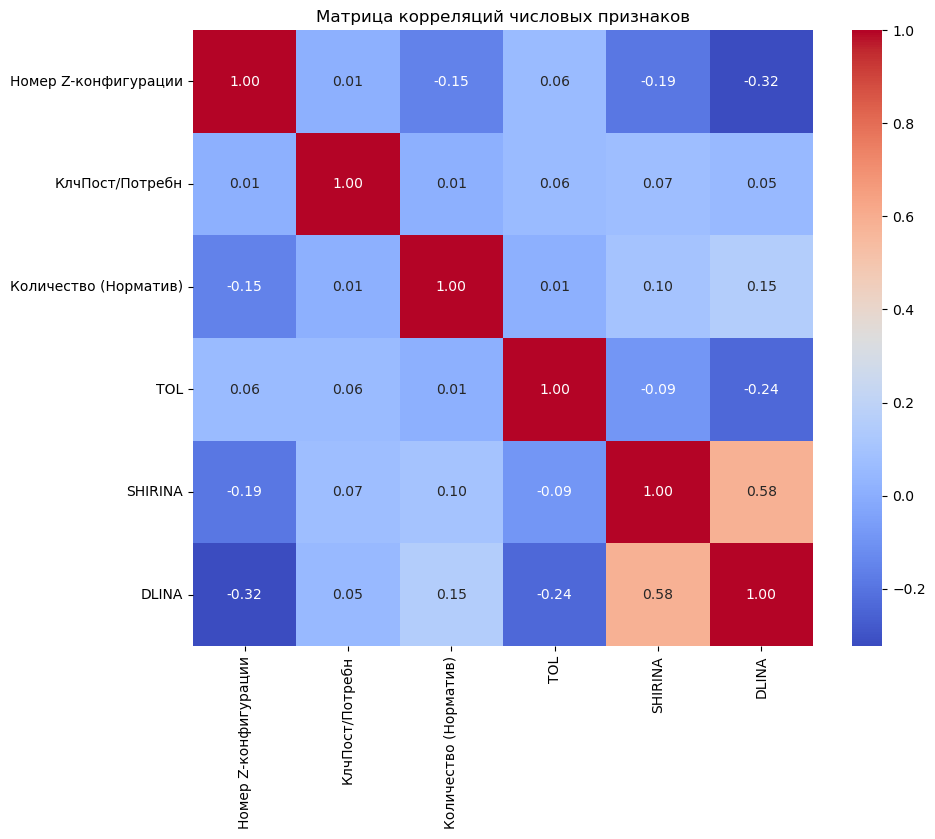

In [24]:
# Матрица корреляций для df
plt.figure(figsize=(10, 8))
corr = df[df_num_col].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Матрица корреляций числовых признаков")
plt.show()

## 5. Обучение моделей кластеризации

### 5.1 Подготовка данных

**Кодирование признаков**

In [28]:
cat_encoders = []
for col in df_cat_col:
    if df[col].nunique() < 20:
        cat_encoders.append((col, OneHotEncoder(handle_unknown='ignore'), [col]))
    else:
        cat_encoders.append((col, OrdinalEncoder(), [col]))

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), df_num_col)] + cat_encoders,
    remainder='drop'
)

X = preprocessor.fit_transform(df)
X = X.toarray() if hasattr(X, 'toarray') else X
print(f"Размерность данных после кодирования: {X.shape}")

Размерность данных после кодирования: (1162, 16)


**Определим оптимальное число кластеров**

In [30]:
def optimal_kmeans_clusters(X, max_k=10):
    best_k, best_score = 2, -1
    for k in range(2, min(max_k, X.shape[0]-1)):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_k, best_score = k, score
    print(f"Оптимальное число кластеров: {best_k}")
    return best_k

optimal_k = optimal_kmeans_clusters(X)

Оптимальное число кластеров: 4


### 5.2 FAISS кластеризация

In [32]:
def faiss_hierarchical_clustering_cpu(X, n_clusters):
    X = np.ascontiguousarray(X.astype('float32'))
    kmeans = faiss.Kmeans(
        d=X.shape[1],
        k=n_clusters,
        niter=25,
        verbose=False,
        gpu=False
    )
    kmeans.train(X)
    D, I = kmeans.index.search(X, 1)
    return I.flatten()

labels_faiss = faiss_hierarchical_clustering_cpu(X, n_clusters=optimal_k)
df["cluster"] = labels_faiss

### 5.3 Unsupervised decision trees кластеризация

In [34]:
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X, labels_faiss)

DecisionTreeClassifier(max_depth=4, random_state=42)

### 5.4 Визуализация результатов

**Визуализация кластеров в PCA**

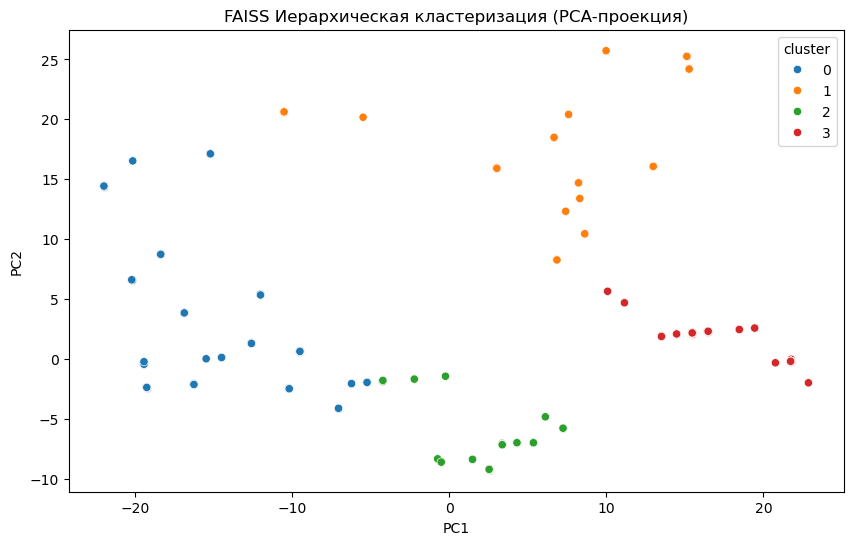

In [37]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df["cluster"], palette="tab10")
plt.title("FAISS Иерархическая кластеризация (PCA-проекция)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

**Визуализация кол-ва объектов по кластерам**

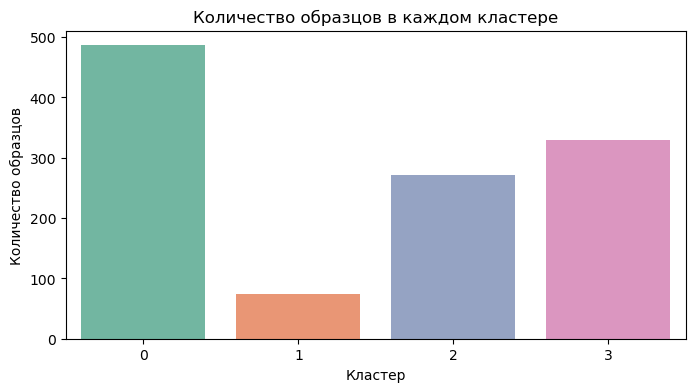

In [39]:
plt.figure(figsize=(8, 4))
sns.countplot(x="cluster", data=df, palette="Set2")
plt.title("Количество образцов в каждом кластере")
plt.xlabel("Кластер")
plt.ylabel("Количество образцов")
plt.show()

**Распределение таргета по кластерам**

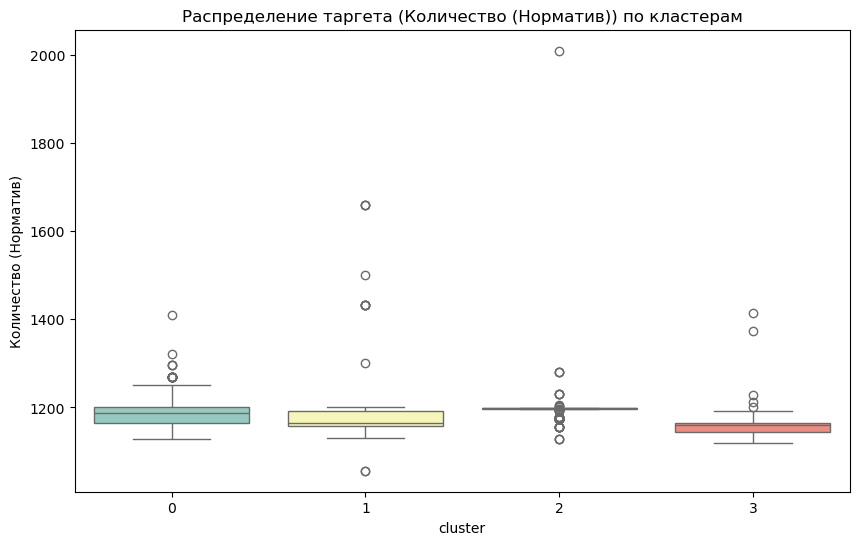

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="cluster", y="Количество (Норматив)", data=df, palette="Set3")
plt.title(f"Распределение таргета ({"Количество (Норматив)"}) по кластерам")
plt.show()

**Средние значения признаков по кластерам**

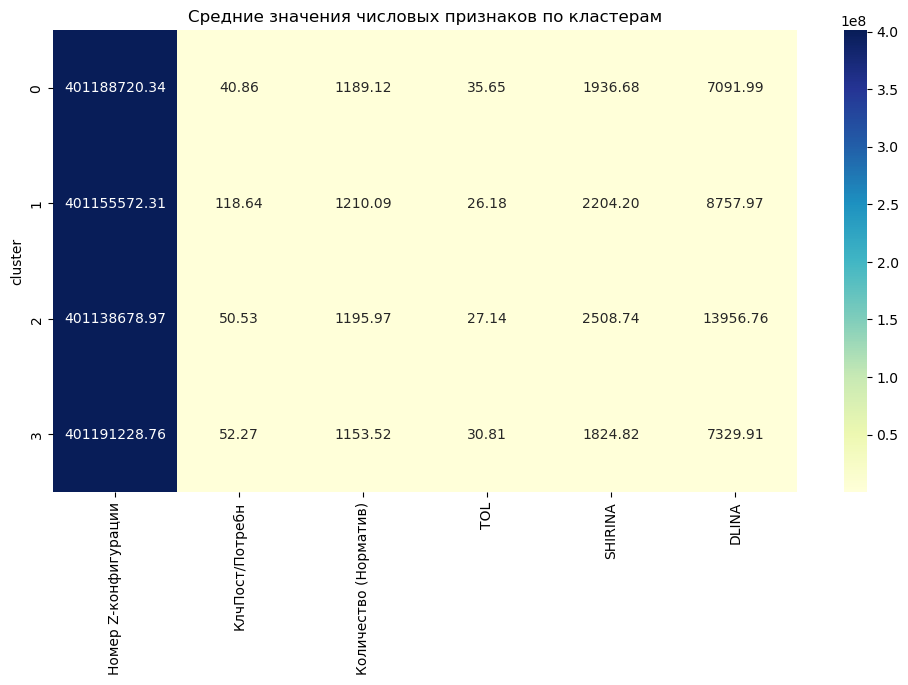

In [43]:
num_for_mean = df_num_col.copy()
if "cluster" in num_for_mean:
    num_for_mean.remove("cluster")

cluster_means = df.groupby("cluster")[num_for_mean].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Средние значения числовых признаков по кластерам")
plt.show()

**Визуализация дерева решений**

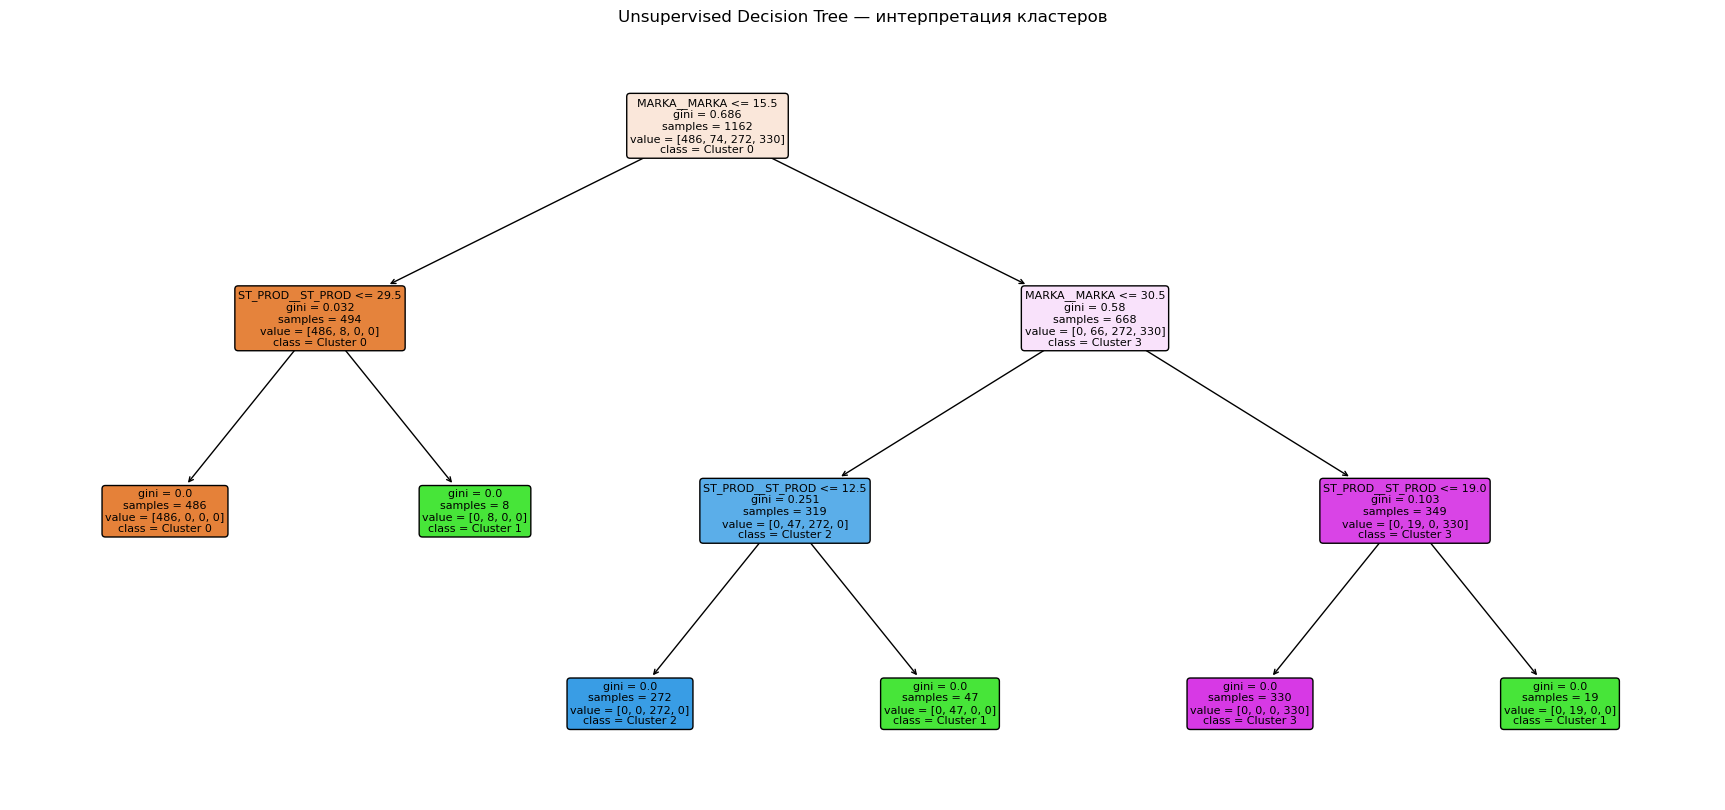

In [45]:
feature_names = preprocessor.get_feature_names_out()
plt.figure(figsize=(22, 10))
plot_tree(
    tree,
    filled=True,
    feature_names=feature_names,
    class_names=[f"Cluster {i}" for i in np.unique(labels_faiss)],
    rounded=True,
    fontsize=8
)
plt.title("Unsupervised Decision Tree — интерпретация кластеров")
plt.show()